# Torchvision Semantic Models

torchvision自带了能够进行自然图像分割的两大类, 共四种模型.

- [FCN](https://arxiv.org/abs/1411.4038)
    - ResNet 50
    - ResNet 101
- [DeeplabV3](https://arxiv.org/abs/1706.05587)
    - ResNet 50
    - ResNet 101
    
使用过程十分方便.    


```
model_urls = {
    'fcn_resnet50_coco': None,	    'fcn_resnet50_coco': 'https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth',
    'fcn_resnet101_coco': 'https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth',	    'fcn_resnet101_coco': 'https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth',
    'deeplabv3_resnet50_coco': None,	    'deeplabv3_resnet50_coco': 'https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth',
    'deeplabv3_resnet101_coco': 'https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth',	    'deeplabv3_resnet101_coco': 'https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth',
}	}
```

```
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to C:\Users\qi/.cache\torch\checkpoints\fcn_resnet101_coco-7ecb50ca.pth
```

```python
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101, deeplabv3_resnet50, deeplabv3_resnet101
fcn_resnet101 = fcn_resnet101(pretrained=True)
# fcn_resnet50 =fcn_resnet50(pretrained=True)
# deeplabv3_resnet50 =deeplabv3_resnet50(pretrained=True)
deeplabv3_resnet101=deeplabv3_resnet101(pretrained=True)
```

最新版本的torchvision才支持预训练的resnot50模型.

In [1]:
import re
import os
import sys
import torch
import glob
from urllib.parse import urlparse

import torch.utils.model_zoo as model_zoo
from torchvision import models

sys.path.append('.')
sys.path.append('..')

from pretrained_models_torch import load_model

In [2]:
model_name = 'fcn_resnet101'
model_dir = '../pretrained'
model_path = glob.glob('../pretrained/{}_[a-z0-9]*'.format(model_name))[0]


fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=False)
deeplabv3_resnet101 = models.segmentation.deeplabv3_resnet101(pretrained=False)

In [3]:
model_path

'../pretrained\\fcn_resnet101_coco-7ecb50ca.pth'

In [4]:
# # load checkpoint
# model.load_state_dict({
#     k.replace('module.',''):v for k, v in torch.load(model_path)['state_dict'].items()
#     })

In [5]:
checkpoint = torch.load(model_path)

# https://discuss.pytorch.org/t/missing-keys-unexpected-keys-in-state-dict-when-loading-self-trained-model/22379/5
fcn_resnet101.load_state_dict(checkpoint, strict=False)  # strict=False 这个参数不能缺少

_IncompatibleKeys(missing_keys=[], unexpected_keys=['aux_classifier.0.weight', 'aux_classifier.1.weight', 'aux_classifier.1.bias', 'aux_classifier.1.running_mean', 'aux_classifier.1.running_var', 'aux_classifier.1.num_batches_tracked', 'aux_classifier.4.weight', 'aux_classifier.4.bias'])

In [6]:
# 很重要
fcn_resnet101.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

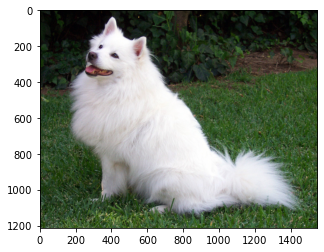

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

img_dir = '../app_uploaded_files/coco/dog.jpg'
img = Image.open(img_dir)
plt.imshow(img)

In [8]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [9]:
# Pass the input through the net
out = fcn_resnet101(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [10]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[ 0 12]


In [11]:

# Define the helper function
def decode_segmap(image, nc=21):

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

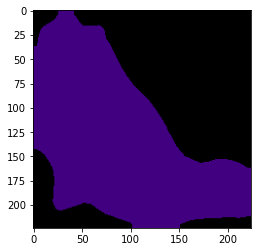

In [12]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [13]:

def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()    


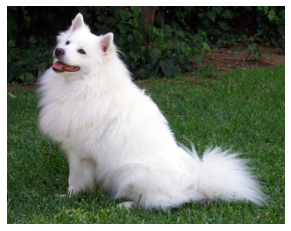

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 4.00 GiB total capacity; 2.76 GiB already allocated; 24.47 MiB free; 2.93 GiB reserved in total by PyTorch)

In [14]:
segment(fcn_resnet101, img_dir)